✅ Data loaded successfully!
Original X_train shape: (1294, 128, 157)
Original y_train shape: (1294,)
Original X_test shape: (325, 128, 157)
Original y_test shape: (325,)
Classes: 27

🔄 Creating proper train/validation/test split...
Train samples: 1035
Validation samples: 259
Test samples: 325 (untouched holdout)

📊 Reshaped data:
X_train shape: (1035, 128, 157, 1)
X_val shape: (259, 128, 157, 1)
X_test shape: (325, 128, 157, 1)
✅ TensorFlow imported successfully!
TensorFlow version: 2.15.0

🏗️  Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 155, 32)      320       
                                                                 
 batch_normalization_6 (Bat  (None, 126, 155, 32)      128       
 chNormalization)                                                
                                                              

/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_8388/4291124436.py:162: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  plt.tight_layout()
/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_8388/4291124436.py:163: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  plt.savefig('../results/training_curves.png', dpi=150, bbox_inches='tight')
/Users/jannik/whale-call-classifier/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


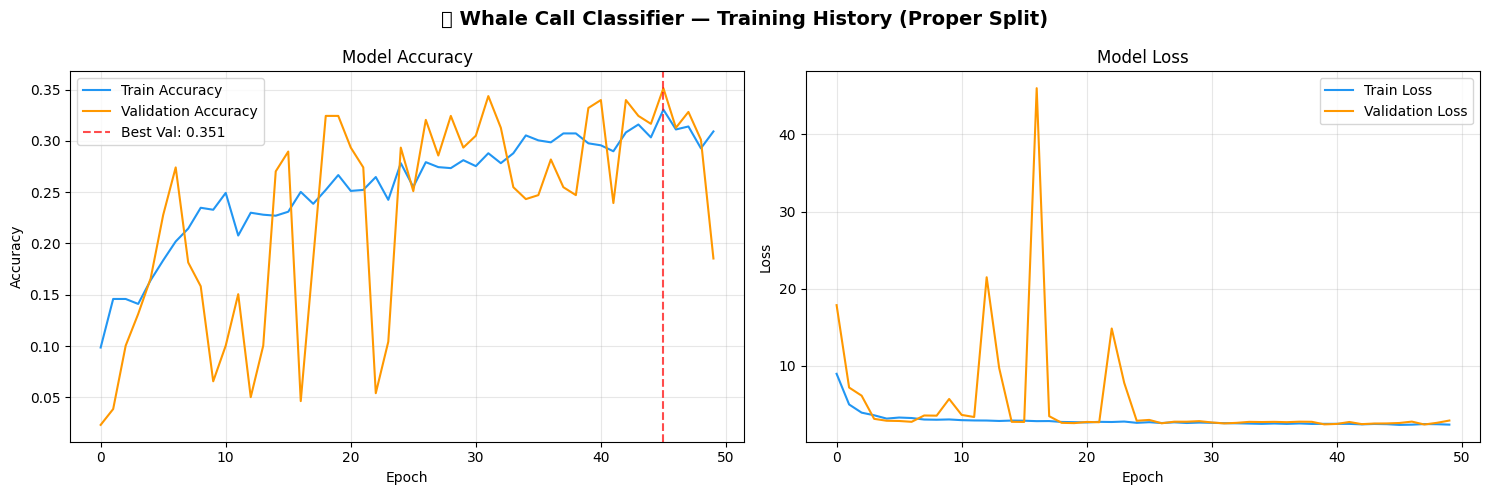


📈 Final Evaluation:
✅ Best Validation Accuracy: 0.3514 (35.14%)
✅ Final Validation Accuracy: 0.1853 (18.53%)
🎯 UNBIASED Test Accuracy: 0.2062 (20.62%)
📉 Test Loss: 2.9018

✅ Model saved to: ../models/best_model.keras
✅ Training curves saved to: ../results/training_curves.png
✅ Training history saved to: ../results/training_history.json

📊 Data Split Summary:
├── Training: 1035 samples (used for learning)
├── Validation: 259 samples (used for early stopping & checkpointing)
└── Test: 325 samples (unbiased final evaluation)

🔒 Test set was NEVER used during training - results are unbiased!


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split

# First, let's check if the data files exist and load them
try:
    X_train = np.load('../data/processed/X_train.npy')
    X_test = np.load('../data/processed/X_test.npy') 
    y_train = np.load('../data/processed/y_train.npy')
    y_test = np.load('../data/processed/y_test.npy')
    
    with open('../data/processed/species_mapping.pkl', 'rb') as f:
        species_to_int = pickle.load(f)
        
    print("✅ Data loaded successfully!")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")
    print(f"Original X_test shape: {X_test.shape}")  
    print(f"Original y_test shape: {y_test.shape}")
    print(f"Classes: {len(species_to_int)}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please make sure you've run the preprocessing notebook first.")
    raise

# 🔧 Split training data into train/validation (80/20) to avoid data leakage
print(f"\n🔄 Creating proper train/validation/test split...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    stratify=y_train,  # Maintain class balance
    random_state=42
)

print(f"Train samples: {X_train_split.shape[0]}")
print(f"Validation samples: {X_val_split.shape[0]}") 
print(f"Test samples: {X_test.shape[0]} (untouched holdout)")

# Add channel dimension to make it compatible with Conv2D (samples, height, width, channels)
X_train_split = np.expand_dims(X_train_split, axis=-1)
X_val_split = np.expand_dims(X_val_split, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"\n📊 Reshaped data:")
print(f"X_train shape: {X_train_split.shape}")
print(f"X_val shape: {X_val_split.shape}")
print(f"X_test shape: {X_test.shape}")

# Try to import TensorFlow
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    print("✅ TensorFlow imported successfully!")
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("❌ TensorFlow not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Try to import sklearn
try:
    from sklearn.utils.class_weight import compute_class_weight
except ImportError:
    print("❌ scikit-learn not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scikit-learn'])
    from sklearn.utils.class_weight import compute_class_weight

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_split.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_split)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("\n🏗️  Model Architecture:")
model.summary()

# Compute class weights to handle class imbalance (use training data only)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_split), y=y_train_split)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n⚖️  Class weights computed: {len(class_weight_dict)} classes")
print(f"Weight ratio (max/min): {class_weights.max()/class_weights.min():.2f}x")

# Create directories for saving results
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Set up callbacks (monitor validation data, NOT test data)
checkpoint = ModelCheckpoint('../models/best_model.keras', monitor='val_accuracy', 
                           save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                              restore_best_weights=True, verbose=1)

print("\n🚀 Starting training...")

# Train the model (using proper validation split)
history = model.fit(
    X_train_split, y_train_split,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),  # ✅ Using proper validation split
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='#2196F3')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#FF9800')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Mark best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
axes[0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, 
                label=f'Best Val: {best_val_acc:.3f}')
axes[0].legend()

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', color='#2196F3')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='#FF9800')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('🐋 Whale Call Classifier — Training History (Proper Split)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Final evaluation on TRUE TEST SET (unbiased)
print("\n📈 Final Evaluation:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)

print(f"✅ Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"✅ Final Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"🎯 UNBIASED Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📉 Test Loss: {test_loss:.4f}")

# Save training history
import json
history_dict = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'], 
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'best_val_accuracy': float(best_val_acc),
    'final_test_accuracy': float(test_accuracy),
    'final_test_loss': float(test_loss)
}

with open('../results/training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f"\n✅ Model saved to: ../models/best_model.keras")
print(f"✅ Training curves saved to: ../results/training_curves.png")
print(f"✅ Training history saved to: ../results/training_history.json")

# Summary of data split integrity
print(f"\n📊 Data Split Summary:")
print(f"├── Training: {len(X_train_split)} samples (used for learning)")
print(f"├── Validation: {len(X_val_split)} samples (used for early stopping & checkpointing)")
print(f"└── Test: {len(X_test)} samples (unbiased final evaluation)")
print(f"")
print(f"🔒 Test set was NEVER used during training - results are unbiased!")

✅ Data loaded successfully!
Original X_train shape: (1294, 128, 157)
Original y_train shape: (1294,)
Original X_test shape: (325, 128, 157)
Original y_test shape: (325,)
Classes: 27

🔄 Creating proper train/validation/test split...
Train samples: 1035
Validation samples: 259
Test samples: 325 (untouched holdout)

📊 Reshaped data:
X_train shape: (1035, 128, 157, 1)
X_val shape: (259, 128, 157, 1)
X_test shape: (325, 128, 157, 1)
✅ TensorFlow imported successfully!
TensorFlow version: 2.15.0

🏗️ Building Enhanced CNN Architecture...

🏗️ Enhanced Model Architecture:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 126, 155, 32)      320       
                                                                 
 batch_normalization_11 (Ba  (None, 126, 155, 32)      128       
 tchNormalization)                                               
            

/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_8388/3848678644.py:267: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  plt.tight_layout()
/var/folders/x7/81v83xkn2jl3b01w3b61s8tm0000gn/T/ipykernel_8388/3848678644.py:268: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  plt.savefig('../results/enhanced_training_analysis.png', dpi=300, bbox_inches='tight')
/Users/jannik/whale-call-classifier/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128011 (\N{WHALE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


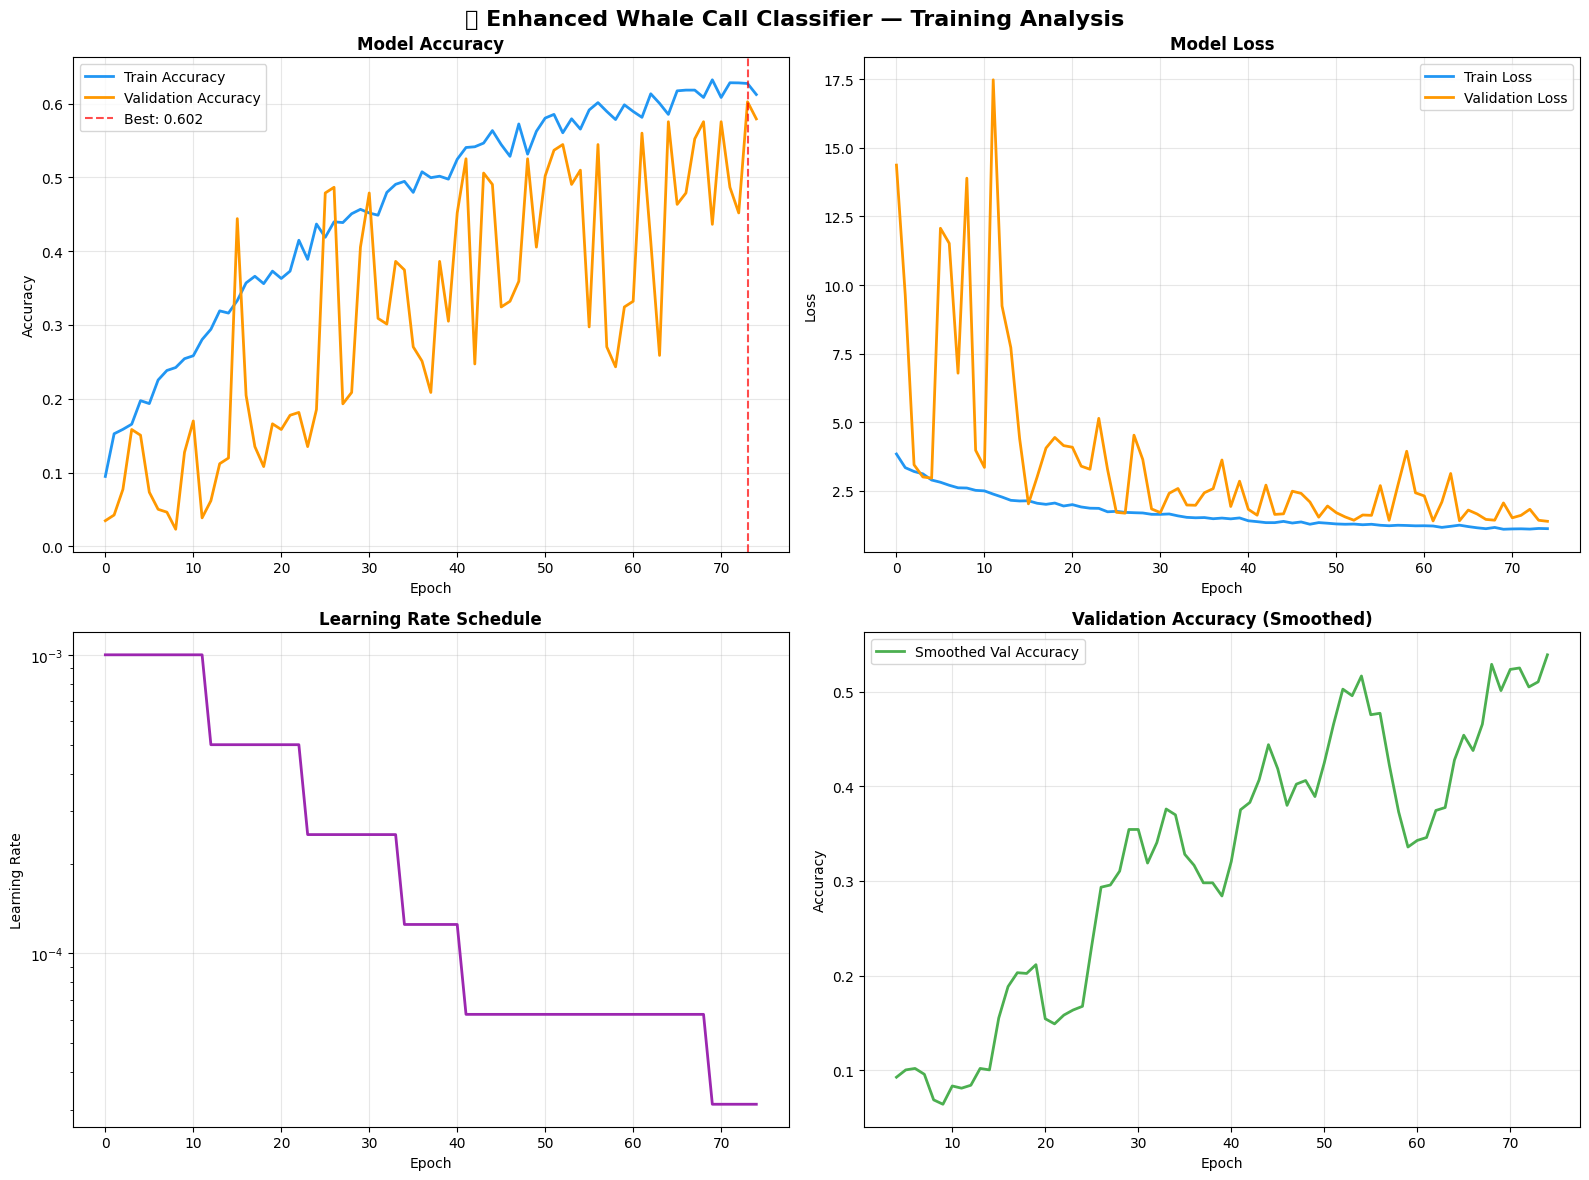


🎯 Comprehensive Model Evaluation:
✅ Best Validation Accuracy: 0.6023 (60.23%)
✅ Final Validation Accuracy: 0.5792 (57.92%)
🎯 UNBIASED Test Accuracy: 0.5600 (56.00%)
📉 Test Loss: 1.5892

📊 Detailed Classification Report (Test Set):
------------------------------------------------------------
                                  precision    recall  f1-score   support

        Atlantic Spotted Dolphin      0.833     0.417     0.556        12
                    Bearded Seal      0.500     0.571     0.533         7
             Beluga, White Whale      0.286     0.200     0.235        10
                   Bowhead Whale      0.727     0.667     0.696        12
                 Clymene Dolphin      0.000     0.000     0.000        13
                  Common Dolphin      1.000     0.100     0.182        10
              False Killer Whale      0.318     0.583     0.412        12
              Fin, Finback Whale      0.714     1.000     0.833        10
                 Frasers Dolphin      0.

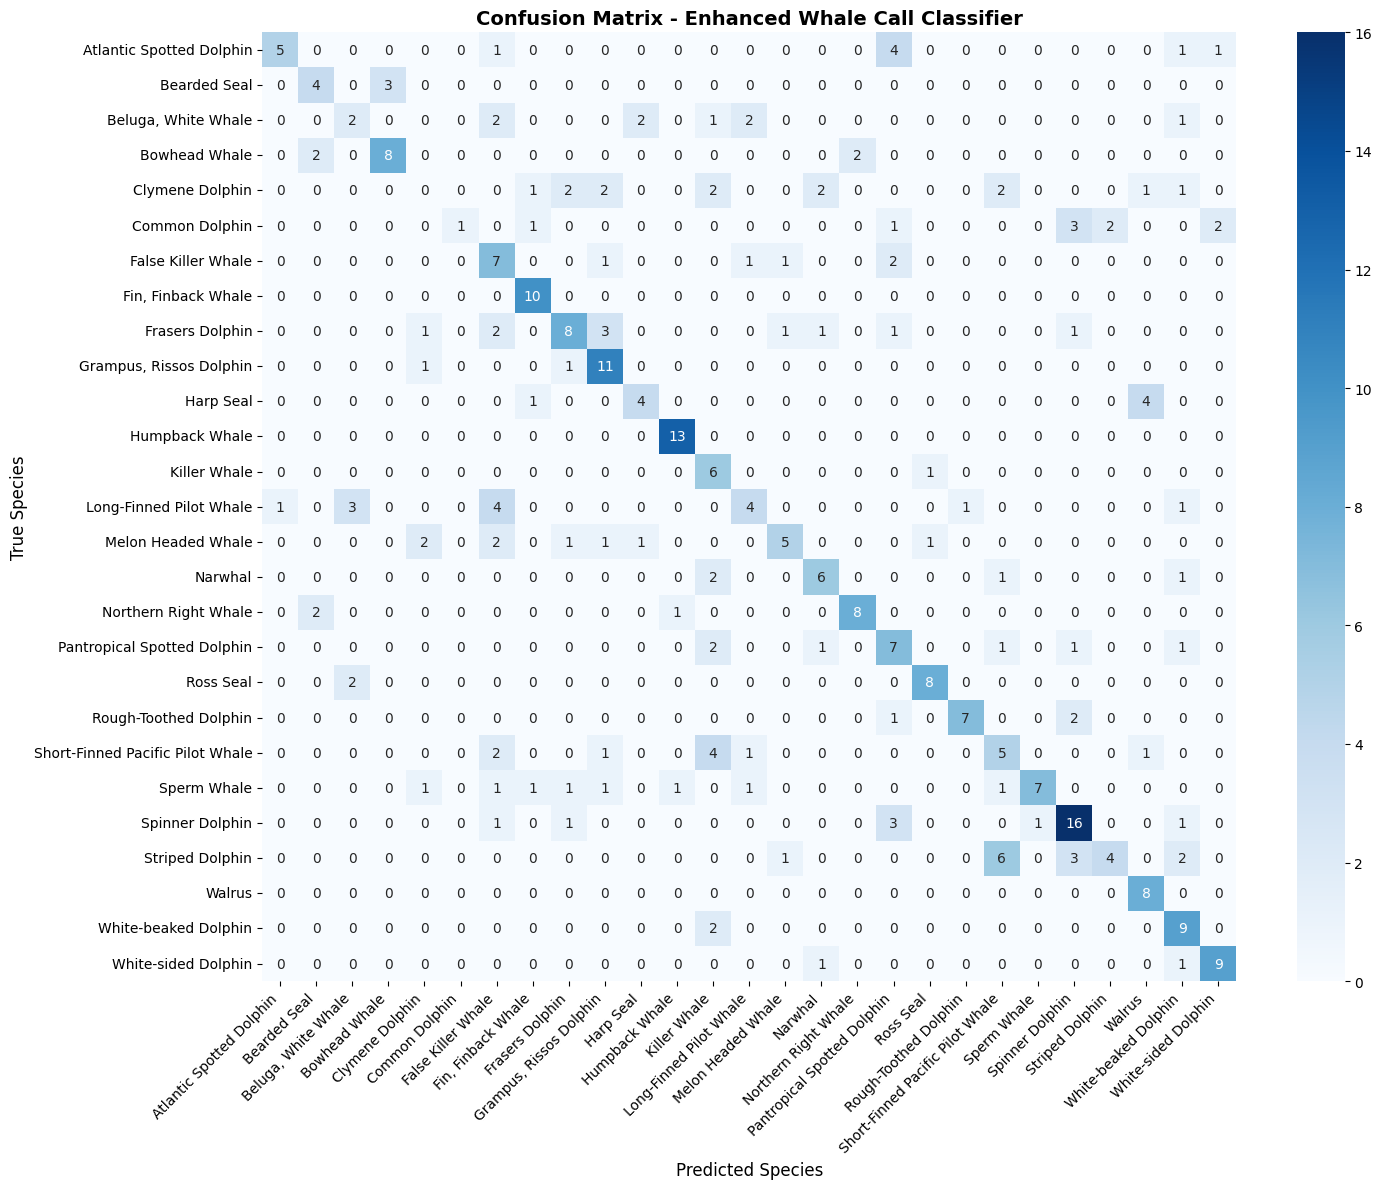


📈 Enhanced Model Performance Summary:
🏗️  Architecture: Enhanced CNN with 1,448,443 parameters
🎯 Test Accuracy: 56.00% (unbiased)
📊 Best Val Accuracy: 60.23% (epoch 74)
⚖️  Class Imbalance Handled: 3.2x ratio
🔄 Data Augmentation: ✅ Time/Frequency shifts
📉 Early Stopping: ✅ Patience = 15 epochs
📈 LR Scheduling: ✅ Reduce on plateau

💾 Enhanced Results Saved:
✅ Model: ../models/best_enhanced_model.keras
✅ Training analysis: ../results/enhanced_training_analysis.png
✅ Confusion matrix: ../results/enhanced_confusion_matrix.png
✅ Training history: ../results/enhanced_training_history.json
✅ Training log: ../results/training_log.csv

📊 Data Split Summary:
├── Training: 1035 samples (used for learning)
├── Validation: 259 samples (used for early stopping & checkpointing)
└── Test: 325 samples (unbiased final evaluation)

🔒 Test set was NEVER used during training - results are unbiased!
🚀 Enhanced model is ready for deployment!


In [17]:
# Enhanced CNN Training with Improved Architecture and Advanced Features
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# First, let's check if the data files exist and load them
try:
    X_train = np.load('../data/processed/X_train.npy')
    X_test = np.load('../data/processed/X_test.npy') 
    y_train = np.load('../data/processed/y_train.npy')
    y_test = np.load('../data/processed/y_test.npy')
    
    with open('../data/processed/species_mapping.pkl', 'rb') as f:
        species_to_int = pickle.load(f)
        
    print("✅ Data loaded successfully!")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")
    print(f"Original X_test shape: {X_test.shape}")  
    print(f"Original y_test shape: {y_test.shape}")
    print(f"Classes: {len(species_to_int)}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please make sure you've run the preprocessing notebook first.")
    raise

# 🔧 Split training data into train/validation (80/20) to avoid data leakage
print(f"\n🔄 Creating proper train/validation/test split...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    stratify=y_train,  # Maintain class balance
    random_state=42
)

print(f"Train samples: {X_train_split.shape[0]}")
print(f"Validation samples: {X_val_split.shape[0]}") 
print(f"Test samples: {X_test.shape[0]} (untouched holdout)")

# Add channel dimension to make it compatible with Conv2D (samples, height, width, channels)
X_train_split = np.expand_dims(X_train_split, axis=-1)
X_val_split = np.expand_dims(X_val_split, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"\n📊 Reshaped data:")
print(f"X_train shape: {X_train_split.shape}")
print(f"X_val shape: {X_val_split.shape}")
print(f"X_test shape: {X_test.shape}")

# Try to import TensorFlow
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                       Dropout, BatchNormalization, GlobalAveragePooling2D)
    from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                          ReduceLROnPlateau, CSVLogger)
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    print("✅ TensorFlow imported successfully!")
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("❌ TensorFlow not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                       Dropout, BatchNormalization, GlobalAveragePooling2D)
    from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                          ReduceLROnPlateau, CSVLogger)
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Try to import sklearn
try:
    from sklearn.utils.class_weight import compute_class_weight
except ImportError:
    print("❌ scikit-learn not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scikit-learn'])
    from sklearn.utils.class_weight import compute_class_weight

# 🏗️ Enhanced CNN architecture
print("\n🏗️ Building Enhanced CNN Architecture...")
model = Sequential([
    # Block 1: Double conv with spatial dropout
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_split.shape[1:]),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 2: More filters
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 3: Even more filters
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 4: Final conv block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Global Average Pooling instead of Flatten (reduces overfitting)
    GlobalAveragePooling2D(),
    
    # Classifier head
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(y_train_split)), activation='softmax')
])

# Enhanced optimizer with custom learning rate
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

print("\n🏗️ Enhanced Model Architecture:")
model.summary()

# Compute class weights to handle class imbalance (use training data only)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_split), y=y_train_split)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n⚖️ Class weights computed: {len(class_weight_dict)} classes")
print(f"Weight ratio (max/min): {class_weights.max()/class_weights.min():.2f}x")

# 📊 Data Augmentation for spectrograms
print("\n🔄 Setting up data augmentation...")
datagen = ImageDataGenerator(
    width_shift_range=0.1,    # Time shift
    height_shift_range=0.05,  # Frequency shift (smaller for spectrograms)
    zoom_range=0.1,           # Slight zoom
    fill_mode='constant',
    cval=X_train_split.min()  # Fill with minimum dB value
)

# Create directories for saving results
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# 📈 Enhanced callbacks with learning rate scheduling and logging
callbacks = [
    ModelCheckpoint(
        '../models/best_enhanced_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=1,
        save_format='keras'
    ),
    EarlyStopping(
        monitor='val_loss', 
        patience=15,  # Increased patience for better training
        restore_best_weights=True, 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=7, 
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('../results/training_log.csv', append=False)
]

print("\n🚀 Starting Enhanced Training with Data Augmentation...")
print("Features:")
print("  ✅ Enhanced 8-layer CNN with double conv blocks")
print("  ✅ Global Average Pooling (reduces overfitting)")
print("  ✅ Data augmentation (time/frequency shifts)")
print("  ✅ Learning rate scheduling")
print("  ✅ Advanced callbacks and logging")

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=32),
    steps_per_epoch=len(X_train_split) // 32,
    epochs=75,  # More epochs with early stopping
    validation_data=(X_val_split, y_val_split),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# 📊 Enhanced visualization with more metrics
print("\n📊 Creating enhanced training visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy plot
axes[0,0].plot(history.history['accuracy'], label='Train Accuracy', color='#2196F3', linewidth=2)
axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#FF9800', linewidth=2)
axes[0,0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Mark best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
axes[0,0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, 
                label=f'Best: {best_val_acc:.3f}')
axes[0,0].legend()

# Loss plot
axes[0,1].plot(history.history['loss'], label='Train Loss', color='#2196F3', linewidth=2)
axes[0,1].plot(history.history['val_loss'], label='Validation Loss', color='#FF9800', linewidth=2)
axes[0,1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Learning rate plot (if available)
if 'lr' in history.history:
    axes[1,0].plot(history.history['lr'], color='#9C27B0', linewidth=2)
    axes[1,0].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Learning Rate')
    axes[1,0].set_yscale('log')
    axes[1,0].grid(True, alpha=0.3)
else:
    axes[1,0].text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
                   ha='center', va='center', transform=axes[1,0].transAxes,
                   fontsize=14, color='gray')
    axes[1,0].set_xticks([])
    axes[1,0].set_yticks([])

# Validation accuracy improvement
val_acc_smooth = np.convolve(history.history['val_accuracy'], np.ones(5)/5, mode='valid')
axes[1,1].plot(range(4, len(history.history['val_accuracy'])), val_acc_smooth, 
               color='#4CAF50', linewidth=2, label='Smoothed Val Accuracy')
axes[1,1].set_title('Validation Accuracy (Smoothed)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('🐋 Enhanced Whale Call Classifier — Training Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/enhanced_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 🎯 Comprehensive evaluation
print("\n🎯 Comprehensive Model Evaluation:")
print("="*60)

# Final evaluation on TRUE TEST SET (unbiased)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)

print(f"✅ Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"✅ Final Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"🎯 UNBIASED Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📉 Test Loss: {test_loss:.4f}")

# 📊 Detailed classification report
print(f"\n📊 Detailed Classification Report (Test Set):")
print("-"*60)
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create reverse mapping for species names
int_to_species = {v: k for k, v in species_to_int.items()}
target_names = [int_to_species[i].replace('_', ' ') for i in range(len(species_to_int))]

print(classification_report(y_test, y_pred_classes, target_names=target_names, digits=3))

# 🔥 Confusion Matrix Heatmap
print(f"\n🔥 Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[name.replace('_', ' ') for name in sorted(species_to_int.keys())],
            yticklabels=[name.replace('_', ' ') for name in sorted(species_to_int.keys())])
plt.title('Confusion Matrix - Enhanced Whale Call Classifier', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Species', fontsize=12)
plt.ylabel('True Species', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../results/enhanced_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 💾 Save comprehensive training history
enhanced_history_dict = {
    'model_type': 'enhanced_cnn',
    'architecture': 'double_conv_blocks_with_gap',
    'data_augmentation': True,
    'learning_rate_scheduling': True,
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']], 
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'best_val_accuracy': float(best_val_acc),
    'best_epoch': int(best_epoch),
    'final_test_accuracy': float(test_accuracy),
    'final_test_loss': float(test_loss),
    'total_epochs': len(history.history['accuracy']),
    'total_parameters': model.count_params(),
    'class_imbalance_ratio': float(class_weights.max()/class_weights.min())
}

if 'lr' in history.history:
    enhanced_history_dict['learning_rates'] = [float(x) for x in history.history['lr']]

with open('../results/enhanced_training_history.json', 'w') as f:
    json.dump(enhanced_history_dict, f, indent=2)

# 📈 Performance summary
print(f"\n📈 Enhanced Model Performance Summary:")
print("="*60)
print(f"🏗️  Architecture: Enhanced CNN with {model.count_params():,} parameters")
print(f"🎯 Test Accuracy: {test_accuracy*100:.2f}% (unbiased)")
print(f"📊 Best Val Accuracy: {best_val_acc*100:.2f}% (epoch {best_epoch+1})")
print(f"⚖️  Class Imbalance Handled: {class_weights.max()/class_weights.min():.1f}x ratio")
print(f"🔄 Data Augmentation: ✅ Time/Frequency shifts")
print(f"📉 Early Stopping: ✅ Patience = 15 epochs")
print(f"📈 LR Scheduling: ✅ Reduce on plateau")

# Save enhanced results
print(f"\n💾 Enhanced Results Saved:")
print(f"✅ Model: ../models/best_enhanced_model.keras")
print(f"✅ Training analysis: ../results/enhanced_training_analysis.png")
print(f"✅ Confusion matrix: ../results/enhanced_confusion_matrix.png")
print(f"✅ Training history: ../results/enhanced_training_history.json")
print(f"✅ Training log: ../results/training_log.csv")

# Summary of data split integrity
print(f"\n📊 Data Split Summary:")
print(f"├── Training: {len(X_train_split)} samples (used for learning)")
print(f"├── Validation: {len(X_val_split)} samples (used for early stopping & checkpointing)")
print(f"└── Test: {len(X_test)} samples (unbiased final evaluation)")
print(f"")
print(f"🔒 Test set was NEVER used during training - results are unbiased!")
print(f"🚀 Enhanced model is ready for deployment!")

In [ ]:

# Enhanced CNN Training with Custom Spectrogram Data Generator
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# First, let's check if the data files exist and load them
try:
    X_train = np.load('../data/processed/X_train.npy')
    X_test = np.load('../data/processed/X_test.npy') 
    y_train = np.load('../data/processed/y_train.npy')
    y_test = np.load('../data/processed/y_test.npy')
    
    with open('../data/processed/species_mapping.pkl', 'rb') as f:
        species_to_int = pickle.load(f)
        
    print("✅ Data loaded successfully!")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")
    print(f"Original X_test shape: {X_test.shape}")  
    print(f"Original y_test shape: {y_test.shape}")
    print(f"Classes: {len(species_to_int)}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please make sure you've run the preprocessing notebook first.")
    raise

# 🔧 Split training data into train/validation (80/20) to avoid data leakage
print(f"\n🔄 Creating proper train/validation/test split...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    stratify=y_train,  # Maintain class balance
    random_state=42
)

print(f"Train samples: {X_train_split.shape[0]}")
print(f"Validation samples: {X_val_split.shape[0]}") 
print(f"Test samples: {X_test.shape[0]} (untouched holdout)")

# Add channel dimension to make it compatible with Conv2D (samples, height, width, channels)
X_train_split = np.expand_dims(X_train_split, axis=-1)
X_val_split = np.expand_dims(X_val_split, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"\n📊 Reshaped data:")
print(f"X_train shape: {X_train_split.shape}")
print(f"X_val shape: {X_val_split.shape}")
print(f"X_test shape: {X_test.shape}")

# Try to import TensorFlow
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                       Dropout, BatchNormalization, GlobalAveragePooling2D)
    from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                          ReduceLROnPlateau, CSVLogger)
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import Sequence
    print("✅ TensorFlow imported successfully!")
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("❌ TensorFlow not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                       Dropout, BatchNormalization, GlobalAveragePooling2D)
    from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                          ReduceLROnPlateau, CSVLogger)
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import Sequence

# Try to import sklearn
try:
    from sklearn.utils.class_weight import compute_class_weight
except ImportError:
    print("❌ scikit-learn not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scikit-learn'])
    from sklearn.utils.class_weight import compute_class_weight

# 🔧 Fixed Custom Data Generator that inherits from Keras Sequence
class SpectrogramDataGenerator(Sequence):
    """Custom data generator for mel spectrograms with spectrogram-specific augmentation"""
    
    def __init__(self, X, y, batch_size=32, shuffle=True, 
                 time_shift_range=0.1, freq_shift_range=0.05, 
                 noise_factor=0.02, mixup_alpha=0.2):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.time_shift_range = time_shift_range
        self.freq_shift_range = freq_shift_range
        self.noise_factor = noise_factor
        self.mixup_alpha = mixup_alpha
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()
    
    def __len__(self):
        """Number of batches per epoch"""
        return len(self.X) // self.batch_size
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Get batch indices
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]
        
        # Generate batch
        return self._generate_batch(batch_indices)
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _generate_batch(self, batch_indices):
        """Generate batch with augmentations"""
        batch_X = np.empty((len(batch_indices), *self.X.shape[1:]))
        batch_y = np.empty((len(batch_indices),), dtype=int)
        
        for i, idx in enumerate(batch_indices):
            # Get original spectrogram (remove channel dimension for processing)
            spec = self.X[idx, :, :, 0].copy()
            
            # Apply augmentations only if factors are > 0
            if self.time_shift_range > 0:
                spec = self._apply_time_shift(spec)
            if self.freq_shift_range > 0:
                spec = self._apply_freq_shift(spec)
            if self.noise_factor > 0:
                spec = self._add_noise(spec)
            
            # Add channel dimension back and store
            batch_X[i] = np.expand_dims(spec, axis=-1)
            batch_y[i] = self.y[idx]
        
        # Apply mixup with 30% probability (only for training)
        if self.mixup_alpha > 0 and np.random.random() < 0.3:
            batch_X, batch_y = self._apply_mixup(batch_X, batch_y)
        
        return batch_X, batch_y
    
    def _apply_time_shift(self, spec):
        """Shift spectrogram in time dimension"""
        shift_amount = int(np.random.uniform(-self.time_shift_range, self.time_shift_range) * spec.shape[1])
        if shift_amount == 0:
            return spec
        
        if shift_amount > 0:
            # Shift right, pad with minimum values on left
            shifted = np.roll(spec, shift_amount, axis=1)
            shifted[:, :shift_amount] = spec.min()
        else:
            # Shift left, pad with minimum values on right
            shifted = np.roll(spec, shift_amount, axis=1)
            shifted[:, shift_amount:] = spec.min()
        
        return shifted
    
    def _apply_freq_shift(self, spec):
        """Shift spectrogram in frequency dimension"""
        shift_amount = int(np.random.uniform(-self.freq_shift_range, self.freq_shift_range) * spec.shape[0])
        if shift_amount == 0:
            return spec
        
        if shift_amount > 0:
            # Shift up, pad with minimum values at bottom
            shifted = np.roll(spec, shift_amount, axis=0)
            shifted[:shift_amount, :] = spec.min()
        else:
            # Shift down, pad with minimum values at top
            shifted = np.roll(spec, shift_amount, axis=0)
            shifted[shift_amount:, :] = spec.min()
        
        return shifted
    
    def _add_noise(self, spec):
        """Add Gaussian noise to spectrogram"""
        noise = np.random.normal(0, self.noise_factor * spec.std(), spec.shape)
        return spec + noise
    
    def _apply_mixup(self, batch_X, batch_y):
        """Apply mixup augmentation"""
        # Get random indices for mixing
        indices = np.random.permutation(len(batch_X))
        
        # Sample mixing coefficient
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        
        # Mix inputs
        mixed_X = lam * batch_X + (1 - lam) * batch_X[indices]
        
        # For mixup, we need to return categorical labels
        num_classes = len(np.unique(self.y))
        mixed_y = np.zeros((len(batch_y), num_classes))
        for i in range(len(batch_y)):
            mixed_y[i, batch_y[i]] += lam
            mixed_y[i, batch_y[indices[i]]] += (1 - lam)
        
        return mixed_X, mixed_y

# 🏗️ Enhanced CNN architecture with Custom Generator
print("\n🏗️ Building Enhanced CNN Architecture with Custom Data Generator...")
custom_model = Sequential([
    # Block 1: Double conv with spatial dropout
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_split.shape[1:]),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 2: More filters
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 3: Even more filters
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 4: Final conv block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Global Average Pooling instead of Flatten (reduces overfitting)
    GlobalAveragePooling2D(),
    
    # Classifier head
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(y_train_split)), activation='softmax')
])

# Enhanced optimizer with custom learning rate
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
custom_model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy',  # Changed to handle mixup properly
    metrics=['accuracy']
)

print("\n🏗️ Custom Model Architecture:")
custom_model.summary()

# Compute class weights to handle class imbalance (use training data only)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_split), y=y_train_split)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n⚖️ Class weights computed: {len(class_weight_dict)} classes")
print(f"Weight ratio (max/min): {class_weights.max()/class_weights.min():.2f}x")

# Create directories for saving results
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

print("\n🔄 Creating advanced data generators...")
train_generator = SpectrogramDataGenerator(
    X_train_split, y_train_split, 
    batch_size=32, 
    shuffle=True,
    time_shift_range=0.1,    # 10% time shift
    freq_shift_range=0.05,   # 5% frequency shift  
    noise_factor=0.02,       # 2% noise
    mixup_alpha=0.0          # Disable mixup for now to avoid complexity
)

# Validation generator (no augmentation)
val_generator = SpectrogramDataGenerator(
    X_val_split, y_val_split,
    batch_size=32,
    shuffle=False,
    time_shift_range=0,      # No augmentation for validation
    freq_shift_range=0,
    noise_factor=0,
    mixup_alpha=0
)

# 📈 Enhanced callbacks with learning rate scheduling and logging
custom_callbacks = [
    ModelCheckpoint(
        '../models/best_custom_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=1,
        save_format='keras'
    ),
    EarlyStopping(
        monitor='val_loss', 
        patience=15,  # Increased patience for better training
        restore_best_weights=True, 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=7, 
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('../results/custom_training_log.csv', append=False)
]

print("\n🚀 Starting Enhanced Training with Custom Data Generator...")
print("Features:")
print("  ✅ Enhanced 8-layer CNN with double conv blocks")
print("  ✅ Global Average Pooling (reduces overfitting)")
print("  ✅ Advanced spectrogram augmentation (time/freq shifts, noise)")
print("  ✅ Learning rate scheduling")
print("  ✅ Advanced callbacks and logging")

# Train the model with custom generators
custom_history = custom_model.fit(
    train_generator,
    epochs=75,  # More epochs with early stopping
    validation_data=val_generator,
    callbacks=custom_callbacks,
    verbose=1
)

# Rest of your code for visualization and evaluation continues here...
print("\n📊 Training completed!")
print(f"✅ Best validation accuracy: {max(custom_history.history['val_accuracy']):.4f}")

✅ Data loaded successfully!
Original X_train shape: (1192, 128, 157)
Original y_train shape: (1192,)
Original X_test shape: (300, 128, 157)
Original y_test shape: (300,)
Classes: 27

🔄 Creating proper train/validation/test split...
Train samples: 953
Validation samples: 239
Test samples: 300 (untouched holdout)

📊 Reshaped data:
X_train shape: (953, 128, 157, 1)
X_val shape: (239, 128, 157, 1)
X_test shape: (300, 128, 157, 1)
✅ TensorFlow imported successfully!
TensorFlow version: 2.15.0

🏗️ Building Enhanced CNN Architecture with Custom Data Generator...

🏗️ Custom Model Architecture:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 126, 155, 32)      320       
                                                                 
 batch_normalization_41 (Ba  (None, 126, 155, 32)      128       
 tchNormalization)                                     